In [5]:
# %%pyspark

#creating correlations
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
import pandas as pd
 
# Start Spark session
spark = SparkSession.builder.appName("Sanitized_Refund_Lakehouse").getOrCreate()

# Step 1: Load the tables as DataFrames
df = spark.read.table("bizdatatotals")
total_df = df.toPandas()
print("Total_df columns:", total_df.columns.tolist(), total_df.dtypes)
df = spark.read.table("bizdatabreakdowns")
breakdown_df = df.toPandas()
print("Breakdown_df columns:", breakdown_df.columns.tolist(), breakdown_df.dtypes)


df  = spark.read.table("df_SAN_Disbursements")
disburse_df = df.toPandas()
print("Disburse_df columns:", disburse_df.columns.tolist(), disburse_df.dtypes)
df = spark.read.table("SAN_ApartmentNameRef")
name_df = df.toPandas()
print("Name_df columns:", name_df.columns.tolist(), name_df.dtypes)
df = spark.read.table("df_SAN_RecipientPayments")
payment_df = df.toPandas()
print("Payment columns:", payment_df.columns.tolist(), payment_df.dtypes)


 



StatementMeta(, 49ec39bf-49e2-487f-b200-fd386a841a25, 7, Finished, Available, Finished)

Total_df columns: ['ZIP', 'NAICS2017', 'NAICS2017_LABEL', 'LFO', 'LFO_LABEL', 'EMPSZES', 'EMPSZES_LABEL', 'YEAR', 'ESTAB', 'PAYANN', 'PAYQTR1', 'EMP', 'EMP_N'] ZIP                object
NAICS2017          object
NAICS2017_LABEL    object
LFO                object
LFO_LABEL          object
EMPSZES            object
EMPSZES_LABEL      object
YEAR               object
ESTAB              object
PAYANN             object
PAYQTR1            object
EMP                object
EMP_N              object
dtype: object
Breakdown_df columns: ['ZIP', 'NAICS2017', 'NAICS2017_LABEL', 'LFO', 'LFO_LABEL', 'EMPSZES', 'EMPSZES_LABEL', 'YEAR', 'ESTAB', 'PAYANN', 'PAYQTR1', 'EMP', 'EMP_N', 'SumOfEstab', 'MaxOfSumOfEstab'] ZIP                 object
NAICS2017           object
NAICS2017_LABEL     object
LFO                 object
LFO_LABEL           object
EMPSZES             object
EMPSZES_LABEL       object
YEAR                object
ESTAB              float64
PAYANN              object
PAYQTR1             o

StatementMeta(, 49ec39bf-49e2-487f-b200-fd386a841a25, 9, Finished, Available, Finished)

/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


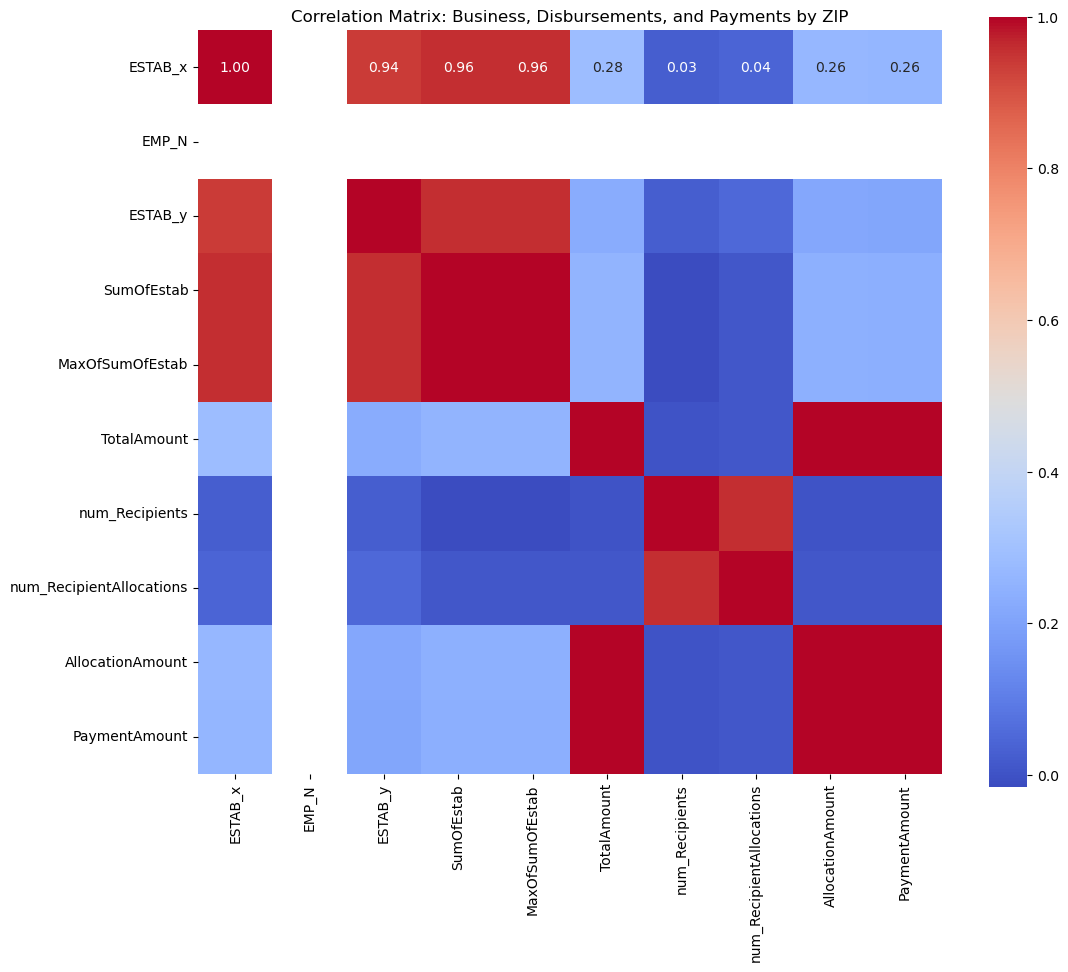

In [7]:
# --- Step 3: Ensure numeric types before grouping ---
 
# Fix total_df

total_df["ESTAB"] = pd.to_numeric(total_df["ESTAB"], errors="coerce")

total_df["EMP_N"] = pd.to_numeric(total_df["EMP_N"], errors="coerce")

total_agg = total_df.groupby("ZIP")[["ESTAB", "EMP_N"]].mean().reset_index()

total_agg = total_agg.rename(columns={"ZIP": "Zip"})  # Rename for merge consistency
 
# Fix breakdown_df

breakdown_df["ESTAB"] = pd.to_numeric(breakdown_df["ESTAB"], errors="coerce")

breakdown_df["SumOfEstab"] = pd.to_numeric(breakdown_df["SumOfEstab"], errors="coerce")

breakdown_df["MaxOfSumOfEstab"] = pd.to_numeric(breakdown_df["MaxOfSumOfEstab"], errors="coerce")

breakdown_agg = breakdown_df.groupby("ZIP")[["ESTAB", "SumOfEstab", "MaxOfSumOfEstab"]].mean().reset_index()

breakdown_agg = breakdown_agg.rename(columns={"ZIP": "Zip"})
 
# Fix disburse_with_zip

disburse_with_zip["TotalAmount"] = pd.to_numeric(disburse_with_zip["TotalAmount"], errors="coerce")

disburse_with_zip["num_Recipients"] = pd.to_numeric(disburse_with_zip["num_Recipients"], errors="coerce")

disburse_with_zip["num_RecipientAllocations"] = pd.to_numeric(disburse_with_zip["num_RecipientAllocations"], errors="coerce")

disburse_agg = disburse_with_zip.groupby("Zip")[["TotalAmount", "num_Recipients", "num_RecipientAllocations"]].mean().reset_index()
 
# Fix payment_with_zip

payment_with_zip["AllocationAmount"] = pd.to_numeric(payment_with_zip["AllocationAmount"], errors="coerce")

payment_with_zip["PaymentAmount"] = pd.to_numeric(payment_with_zip["PaymentAmount"], errors="coerce")

payment_agg = payment_with_zip.groupby("Zip")[["AllocationAmount", "PaymentAmount"]].mean().reset_index()
 
# --- Step 4: Merge all by ZIP ---

from functools import reduce
 
dfs = [total_agg, breakdown_agg, disburse_agg, payment_agg]

combined_df = reduce(lambda left, right: pd.merge(left, right, on="Zip", how="outer"), dfs)
 
# --- Step 5: Correlation matrix ---

correlation_data = combined_df.drop(columns=["Zip"])

corr_matrix = correlation_data.corr()
 
# --- Step 6: Plot ---

import seaborn as sns

import matplotlib.pyplot as plt
 
plt.figure(figsize=(12, 10))

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)

plt.title("Correlation Matrix: Business, Disbursements, and Payments by ZIP")

plt.show()

 

In [ ]:
# %%pyspark

from pyspark.sql import SparkSession

import pandas as pd
 
# Start Spark session

spark = SparkSession.builder.appName("Sanitized_Refund_Lakehouse").getOrCreate()
 
# Load data into Spark, then Pandas

df = spark.read.table("bizdatatotals")

total_df = df.toPandas()

df = spark.read.table("bizdatabreakdowns")

breakdown_df = df.toPandas()

 
# Filter out total rows

bizData_df = bizData_df[bizData_df["NAICS2017_LABEL"] != "Total for all sectors"]
 
# Create a string version of ESTAB for addition traceability

bizData_df["ESTAB_STR"] = bizData_df["ESTAB"].astype(str)
 
# Step 1: Group and aggregate

agg_df = bizData_df.groupby(['ZIP', 'NAICS2017_LABEL']).agg(

    SumOfEstab=('ESTAB', 'sum'),

    NumRowsSummed=('ESTAB', 'count'),

    Estab_Addition_Formula=('ESTAB_STR', lambda x: "+".join(x))

).reset_index()
 
# Step 2: Sort with largest SumOfEstab first per ZIP

agg_df = agg_df.sort_values(['ZIP', 'SumOfEstab'], ascending=[True, False])
 
# Display result

display(agg_df)


#try 2

bizData_df["ESTAB"] = pd.to_numeric(bizData_df["ESTAB"], errors='coerce')

print(bizData_df["ESTAB"].dtype)


bizData_df = bizData_df[bizData_df["NAICS2017_LABEL"] != "Total for all sectors"]
 
# Create a string version of ESTAB for addition traceability

bizData_df["ESTAB_STR"] = bizData_df["ESTAB"].astype(str)
 
# Step 1: Group and aggregate

agg_df = bizData_df.groupby(['ZIP', 'NAICS2017_LABEL']).agg(

    SumOfEstab=('ESTAB', 'sum'),

    NumRowsSummed=('ESTAB', 'count'),

    Estab_Addition_Formula=('ESTAB_STR', lambda x: "+".join(x))

).reset_index()

# Step 2: Sort with largest SumOfEstab first per ZIP

agg_df = agg_df.sort_values(['ZIP', 'SumOfEstab'], ascending=[True, False])
 
# Display result

display(agg_df)
 

In [ ]:
# %%pyspark

from pyspark.sql import SparkSession

import pandas as pd
 
spark = SparkSession.builder.appName("Sanitized_Refund_Lakehouse").getOrCreate()
 
# Load Spark table into Pandas

df = spark.read.table("bizdatapartiallyclean")

bizData_df = df.toPandas()
 
# Step 0: Filter out totals

bizData_df = bizData_df[bizData_df["NAICS2017_LABEL"] != "Total for all sectors"]
 
# Step 1: Inspect what's making your rows "explode"

print("First few rows before any grouping:\n", bizData_df.head())

print("\nUnique values in NAICS2017_LABEL:\n", bizData_df["NAICS2017_LABEL"].unique()[:10])

print("\nSample ZIP counts:\n", bizData_df["ZIP"].value_counts().head())
 
# Step 2: Group by ZIP and NAICS to get total ESTAB for each category

grouped = bizData_df.groupby(['ZIP', 'NAICS2017_LABEL'], as_index=False)['ESTAB'].sum()

print("\nGrouped result sample:\n", grouped.head(10))
 
# Step 3: For each ZIP, find the row index with the highest ESTAB

idx = grouped.groupby('ZIP')['ESTAB'].idxmax()
 
# Step 4: Filter down to the max category per ZIP

dominant_categories = grouped.loc[idx].reset_index(drop=True)
 
# Final sanity check

# print("\nFinal row count:", len(dominant_categories))

# print("\nSample output:\n", dominant_categories_)
 

In [19]:
# Welcome to your new notebook
# Type here in the cell editor to add code!
# %%pyspark
from pyspark.sql import SparkSession
import pandas as pd
spark = SparkSession.builder.appName("Sanitized_Refund_Lakehouse").getOrCreate()
 
df = spark.read.table("bizdatapartiallyclean")
bizData_df = df.toPandas()
 
bizData_df = bizData_df[bizData_df["NAICS2017_LABEL"] != "Total for all sectors"]

bizData_df["ESTAB"] = pd.to_numeric(bizData_df["ESTAB"], errors='coerce')

print(bizData_df["ESTAB"].dtype)
 
bizData_df["SumOfEstab"] = bizData_df.groupby(['ZIP','NAICS2017_LABEL'])['ESTAB'].transform('sum')
 
bizData_df["MaxOfSumOfEstab"] = bizData_df.groupby(['ZIP'])['SumOfEstab'].transform('max')
 
bizData_df = bizData_df[bizData_df["SumOfEstab"] == bizData_df['MaxOfSumOfEstab']]
 
display(bizData_df)
 
bizData_df.to_csv("abfss://16a370d4-5a15-45bb-ac81-a743cf19fbad@onelake.dfs.fabric.microsoft.com/488545cc-fe6d-40c4-b609-c1b59c27c985/Files/Businesses/BizDataBreakdowns.csv", index = False)
 
 
duplicate_zips = bizData_df[bizData_df.duplicated(subset='ZIP', keep=False)]

display(duplicate_zips)

 
 
 

StatementMeta(, e93a1986-7adb-4064-94db-0c0d446bb0d4, 21, Finished, Available, Finished)

float64


SynapseWidget(Synapse.DataFrame, 48eb63cf-f4fa-4cad-90e7-0eb8cf90b76a)

SynapseWidget(Synapse.DataFrame, 84deb1b7-c400-4240-a27b-894cc9699822)